In [1]:
# Cell 1: Imports and Path Setup
import sys
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import copy
from datetime import datetime
from tqdm import tqdm

# Add TrajectoryCrafter to Python path
trajcrafter_path = "/home/azhuravl/work/TrajectoryCrafter"
sys.path.insert(0, trajcrafter_path)

# Change working directory to TrajectoryCrafter
os.chdir(trajcrafter_path)

# Now import TrajectoryCrafter modules
from demo import TrajCrafter
from models.utils import Warper, read_video_frames
from models.infer import DepthCrafterDemo
import inference_orbits

print("Imports successful!")
print(f"Working directory: {os.getcwd()}")
print(f"CUDA available: {torch.cuda.is_available()}")

/CT/video_4d_recon/nobackup/conda_envs/trajcrafter/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/CT/video_4d_recon/nobackup/conda_envs/trajcrafter/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_bwd")


Imports successful!
Working directory: /CT/video_4d_recon/work/TrajectoryCrafter
CUDA available: True


In [3]:
# Cell 2: Argument Setup
# Create opts manually for notebook use
parser = inference_orbits.get_parser()
opts_base = parser.parse_args([
    '--video_path', './test/videos/0-NNvgaTcVzAG0-r.mp4',  # Change this path
    '--radius', '1.0',
    '--device', 'cuda:0'
])

# Set common parameters
opts_base.weight_dtype = torch.bfloat16
opts_base.camera = "target"
opts_base.mode = "gradual"
opts_base.mask = True
opts_base.target_pose = [0, 90, opts_base.radius, 0, 0]  # right_90 example

timestamp = datetime.now().strftime("%Y%m%d_%H%M")
video_basename = os.path.splitext(os.path.basename(opts_base.video_path))[0]
opts_base.exp_name = f"{video_basename}_{timestamp}_vis"

print(f"Video: {opts_base.video_path}")
print(f"Target pose: {opts_base.target_pose}")
print(f"Device: {opts_base.device}")

Video: ./test/videos/0-NNvgaTcVzAG0-r.mp4
Target pose: [0, 90, 1.0, 0, 0]
Device: cuda:0


In [99]:
# Cell 3: Visualization Classes
class VisualizationWarper(Warper):
    """Extended Warper class for 3D visualization"""
    
    def extract_3d_points_with_colors(
        self,
        frame1: torch.Tensor,
        depth1: torch.Tensor,
        transformation1: torch.Tensor,
        intrinsic1: torch.Tensor,
        subsample_step: int = 10
    ):
        """Extract 3D world points and their corresponding colors for visualization"""
        b, c, h, w = frame1.shape
        
        # Move tensors to device
        frame1 = frame1.to(self.device).to(self.dtype)
        depth1 = depth1.to(self.device).to(self.dtype)
        transformation1 = transformation1.to(self.device).to(self.dtype)
        intrinsic1 = intrinsic1.to(self.device).to(self.dtype)
        
        # Create subsampled pixel coordinates for performance
        x_coords = torch.arange(0, w, subsample_step, dtype=torch.float32)
        y_coords = torch.arange(0, h, subsample_step, dtype=torch.float32)
        x2d, y2d = torch.meshgrid(x_coords, y_coords, indexing='xy')
        x2d = x2d.to(depth1.device)
        y2d = y2d.to(depth1.device)
        ones_2d = torch.ones_like(x2d)
        
        # Stack into homogeneous coordinates
        pos_vectors_homo = torch.stack([x2d, y2d, ones_2d], dim=2)[None, :, :, :, None]
        
        # Subsample depth and colors
        depth_sub = depth1[:, 0, ::subsample_step, ::subsample_step]
        colors_sub = frame1[:, :, ::subsample_step, ::subsample_step]
        
        # Unproject to 3D camera coordinates
        intrinsic1_inv = torch.linalg.inv(intrinsic1)
        intrinsic1_inv_4d = intrinsic1_inv[:, None, None]
        depth_4d = depth_sub[:, :, :, None, None]
        
        unnormalized_pos = torch.matmul(intrinsic1_inv_4d, pos_vectors_homo)
        camera_points = depth_4d * unnormalized_pos
        
        # Transform to world coordinates
        ones_4d = torch.ones(b, camera_points.shape[1], camera_points.shape[2], 1, 1).to(depth1)
        world_points_homo = torch.cat([camera_points, ones_4d], dim=3)
        trans_4d = transformation1[:, None, None]
        world_points_homo = torch.matmul(trans_4d, world_points_homo)
        world_points = world_points_homo[:, :, :, :3, 0]  # (b, h_sub, w_sub, 3)
        
        # Prepare colors
        colors = colors_sub.permute(0, 2, 3, 1)  # (b, h_sub, w_sub, 3)
        
        # Filter valid points (positive depth)
        valid_mask = depth_sub > 0  # (b, h_sub, w_sub)
        
        # Flatten and filter
        points_3d = world_points[valid_mask]  # (N, 3)
        colors_rgb = colors[valid_mask]       # (N, 3)
        
        return points_3d, colors_rgb


class TrajCrafterVisualization(TrajCrafter):
    """Lightweight TrajCrafter subclass for camera trajectory visualization"""
    
    def __init__(self, opts):
        # Only initialize what we need for pose generation and depth estimation
        self.device = opts.device
        self.depth_estimater = DepthCrafterDemo(
            unet_path=opts.unet_path,
            pre_train_path=opts.pre_train_path,
            cpu_offload=opts.cpu_offload,
            device=opts.device,
        )
        print("TrajCrafterVisualization initialized (diffusion pipeline skipped)")
    
    def extract_scene_data(self, opts):
        """Extract all data needed for 3D visualization"""
        print("Reading video frames...")
        frames = read_video_frames(
            opts.video_path, opts.video_length, opts.stride, opts.max_res
        )
        
        print("Estimating depth...")
        depths = self.depth_estimater.infer(
            frames,
            opts.near,
            opts.far,
            opts.depth_inference_steps,
            opts.depth_guidance_scale,
            window_size=opts.window_size,
            overlap=opts.overlap,
        ).to(opts.device)
        
        print("Converting frames to tensors...")
        frames_tensor = (
            torch.from_numpy(frames).permute(0, 3, 1, 2).to(opts.device) * 2.0 - 1.0
        )
        
        print("Generating camera poses...")
        pose_s, pose_t, K = self.get_poses(opts, depths, num_frames=opts.video_length)
        
        # Calculate scene radius
        radius = (
            depths[0, 0, depths.shape[-2] // 2, depths.shape[-1] // 2].cpu()
            * opts.radius_scale
        )
        radius = min(radius, 5)
        
        return {
            'frames_numpy': frames,
            'frames_tensor': frames_tensor,
            'depths': depths,
            'pose_source': pose_s,
            'pose_target': pose_t,
            'intrinsics': K,
            'radius': radius,
            'trajectory_params': opts.target_pose if hasattr(opts, 'target_pose') else None
        }
        
        
    #################################################
    # Circular trajectory
    #################################################
        
    def generate_circular_trajectory(self, c2ws_anchor, circle_type, radius, num_frames, device, center_offset=(0,0,0)):
        """
        Generate circular camera trajectory
        
        Args:
            c2ws_anchor: Initial camera pose tensor
            circle_type: 'horizontal', 'vertical_xz', 'vertical_yz', or 'tilted'
            radius: Circle radius
            num_frames: Number of frames
            device: torch device
            center_offset: (x,y,z) offset from origin
        """
        angles = np.linspace(0, 2*np.pi, num_frames, endpoint=False)
        c2ws_list = []
        
        for angle in angles:
            c2w = copy.deepcopy(c2ws_anchor)
            
            if circle_type == 'horizontal':
                # Circle in XY plane (horizontal orbit)
                x = radius * np.cos(angle) + center_offset[0]
                y = radius * np.sin(angle) + center_offset[1]
                z = center_offset[2]
                
                # Set camera position
                c2w[0, 0, 3] = x
                c2w[0, 1, 3] = y  
                c2w[0, 2, 3] = z
                
                # Point camera toward center (optional - creates look-at behavior)
                # For now, just translate without rotation
                
            elif circle_type == 'vertical_xz':
                # Circle in XZ plane (side view)
                x = radius * np.cos(angle) + center_offset[0]
                y = center_offset[1]
                z = radius * np.sin(angle) + center_offset[2]
                
                c2w[0, 0, 3] = x
                c2w[0, 1, 3] = y
                c2w[0, 2, 3] = z
                
            elif circle_type == 'vertical_yz':
                # Circle in YZ plane (front view)
                x = center_offset[0]
                y = radius * np.cos(angle) + center_offset[1]
                z = radius * np.sin(angle) + center_offset[2]
                
                c2w[0, 0, 3] = x
                c2w[0, 1, 3] = y
                c2w[0, 2, 3] = z
                
            elif circle_type == 'tilted':
                # 45° tilted circle
                x = radius * np.cos(angle) + center_offset[0]
                y = radius * np.sin(angle) * np.cos(np.pi/4) + center_offset[1]
                z = radius * np.sin(angle) * np.sin(np.pi/4) + center_offset[2]
                
                c2w[0, 0, 3] = x
                c2w[0, 1, 3] = y
                c2w[0, 2, 3] = z
            
            c2ws_list.append(c2w)
        
        return torch.cat(c2ws_list, dim=0)
    
    
    def get_poses_circular(self, opts, depths, num_frames, circle_type='horizontal', custom_radius=None):
        """
        Generate circular camera poses instead of linear interpolation
        
        Args:
            opts: Options object
            depths: Depth maps
            num_frames: Number of frames
            circle_type: Type of circular motion
            custom_radius: Override default radius calculation
        """
        # Calculate radius (same as original)
        if custom_radius is None:
            radius = (
                depths[0, 0, depths.shape[-2] // 2, depths.shape[-1] // 2].cpu()
                * opts.radius_scale
            )
            radius = min(radius, 5)
        else:
            radius = custom_radius
            
        # Camera intrinsics (same as original)
        cx = 512.0
        cy = 288.0  
        f = 500
        K = (
            torch.tensor([[f, 0.0, cx], [0.0, f, cy], [0.0, 0.0, 1.0]])
            .repeat(num_frames, 1, 1)
            .to(opts.device)
        )
        
        # Initial camera pose (same as original)
        c2w_init = (
            torch.tensor([
                [-1.0, 0.0, 0.0, 0.0],
                [0.0, 1.0, 0.0, 0.0], 
                [0.0, 0.0, -1.0, 0.0],
                [0.0, 0.0, 0.0, 1.0],
            ])
            .to(opts.device)
            .unsqueeze(0)
        )
        
        # Generate circular trajectory
        poses = self.generate_circular_trajectory(
            c2w_init, circle_type, radius, num_frames, opts.device
        )
        
        # Apply Z offset (same as original)
        poses[:, 2, 3] = poses[:, 2, 3] + radius
        
        # Source and target poses
        pose_s = poses[opts.anchor_idx : opts.anchor_idx + 1].repeat(num_frames, 1, 1)
        pose_t = poses
        
        return pose_s, pose_t, K
    
 
 # Utility function for easy use
def create_circular_preset_params(preset_name):
    """Create parameters for common circular motion presets"""
    presets = {
        "horizontal_circle": {
            "circle_type": "horizontal",
            "description": "Horizontal circular orbit around scene"
        },
        "vertical_orbit_xz": {
            "circle_type": "vertical_xz", 
            "description": "Vertical orbit in XZ plane (side view)"
        },
        "vertical_orbit_yz": {
            "circle_type": "vertical_yz",
            "description": "Vertical orbit in YZ plane (front view)" 
        },
        "tilted_orbit": {
            "circle_type": "tilted",
            "description": "45° tilted circular orbit"
        }
    }
    return presets.get(preset_name, presets["horizontal_circle"])       
        

print("Classes defined successfully!")

Classes defined successfully!


In [100]:
# Cell 4: Run Visualization
# Initialize visualization TrajCrafter
print("Initializing TrajCrafter for visualization...")
vis_crafter = TrajCrafterVisualization(opts_base)

# Extract scene data
print("Extracting scene data...")
scene_data = vis_crafter.extract_scene_data(opts_base)

# Create warper for 3D point extraction
print("Creating 3D point cloud from all frames...")
vis_warper = VisualizationWarper(device=opts_base.device)

# Extract points from all frames
all_points_3d = []
all_colors_rgb = []

num_frames = scene_data['frames_tensor'].shape[0]
for i in tqdm(range(num_frames), desc="Processing frames"):
    frame_data = {
        'frame': scene_data['frames_tensor'][i:i+1],
        'depth': scene_data['depths'][i:i+1], 
        'pose_source': scene_data['pose_source'][i:i+1],
        'intrinsics': scene_data['intrinsics'][i:i+1],
    }
    
    points_3d_frame, colors_rgb_frame = vis_warper.extract_3d_points_with_colors(
        frame_data['frame'],
        frame_data['depth'], 
        frame_data['pose_source'],
        frame_data['intrinsics'],
        subsample_step=20  # Increased for performance with multiple frames
    )
    
    if points_3d_frame.shape[0] > 0:  # Only add if we have valid points
        all_points_3d.append(points_3d_frame)
        all_colors_rgb.append(colors_rgb_frame)

# Concatenate all points
if all_points_3d:
    points_3d = torch.cat(all_points_3d, dim=0)
    colors_rgb = torch.cat(all_colors_rgb, dim=0)
    print(f"Generated {points_3d.shape[0]} 3D points from {len(all_points_3d)} frames")
else:
    print("No valid 3D points extracted!")
    points_3d = None
    colors_rgb = None

print(f"Camera trajectory: {scene_data['pose_target'].shape[0]} poses")

Initializing TrajCrafter for visualization...


Expected types for unet: ['UNetSpatioTemporalConditionModel'], got DiffusersUNetSpatioTemporalConditionModelDepthCrafter.


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

TrajCrafterVisualization initialized (diffusion pipeline skipped)
Extracting scene data...
Reading video frames...
==> processing video:  ./test/videos/0-NNvgaTcVzAG0-r.mp4
==> original video shape:  (146, 720, 1280, 3)
==> downsampled shape: (146, 576, 1024, 3), with stride: 1
==> final processing shape: (49, 576, 1024, 3)
Estimating depth...
Elapsed time for encoding video: 9515.4501953125 ms


  0%|          | 0/5 [00:00<?, ?it/s]

Elapsed time for denoising video: 20985.404296875 ms
Elapsed time for decoding video: 18729.736328125 ms
Converting frames to tensors...
Generating camera poses...
Creating 3D point cloud from all frames...


Processing frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 497.56it/s]

Generated 73892 3D points from 49 frames
Camera trajectory: 49 poses


In [106]:
# Cell 1: Create Viser Server (run once)
import viser

# Check if server already exists and stop it
try:
    if 'viser_server' in globals() and viser_server is not None:
        print("Stopping existing server...")
        viser_server.stop()
        del viser_server
except:
    pass

# Create new server
print("Creating new Viser server on port 8080...")
viser_server = viser.ViserServer(port=8080)
print("Server started successfully!")

Stopping existing server...


(viser) Connection closed (0, 0 total)

(viser) Server stopped

Creating new Viser server on port 8080...


╭──────────────── viser ────────────────╮
│             ╷                         │
│   HTTP      │ http://localhost:8080   │
│   Websocket │ ws://localhost:8080     │
│             ╵                         │
╰───────────────────────────────────────╯

Server started successfully!


(viser) Connection opened (0, 1 total), 5 persistent messages

In [107]:
# Cell 2: Animated Viser Content
def setup_viser_scene(server, scene_data):
    """Setup static scene elements (trajectory and camera poses)"""

    poses_np = scene_data['pose_target'].cpu().numpy()
    positions = poses_np[:, :3, 3]
    
    # Add trajectory (static)
    server.scene.add_spline_catmull_rom(
        "/trajectory", 
        positions=positions, 
        color=(1.0, 0.0, 0.0), 
        line_width=3.0
    )
    
    # Add all camera poses (static)
    for i, pose in enumerate(poses_np[::2]):  # Every 2nd pose to reduce clutter
        position = pose[:3, 3]
        rotation_matrix = pose[:3, :3]
        
        print(position)
        
        # flip_z = np.array([[-1, 0, 0], [0, 1, 0], [0, 0, -1]])
        # corrected_rotation = rotation_matrix @ flip_z
        
        corrected_rotation = rotation_matrix  # No correction
        wxyz = viser.transforms.SO3.from_matrix(corrected_rotation).wxyz
        
        server.scene.add_camera_frustum(
            f"/camera_{i}",
            fov=60, aspect=16/9, scale=0.15,
            position=position, wxyz=wxyz,
            color=(0.8, 0.2, 0.2)
        )
    
    # Add start/end markers
    server.scene.add_icosphere("/start", radius=0.1, position=positions[0], color=(0.0, 1.0, 0.0))
    server.scene.add_icosphere("/end", radius=0.1, position=positions[-1], color=(1.0, 0.0, 1.0))
    server.scene.add_frame("/world", axes_length=0.5, position=(0, 0, 0), wxyz=(1, 0, 0, 0))

def animate_frame(server, scene_data, frame_idx, max_points=5000):
    """Update only the point cloud for given frame"""
    # Clear previous frame
    try:
        server.scene.remove("/current_frame")
        server.scene.remove("/current_camera")
    except:
        pass
    
    # Extract points for this frame
    frame_data = {
        'frame': scene_data['frames_tensor'][frame_idx:frame_idx+1],
        'depth': scene_data['depths'][frame_idx:frame_idx+1], 
        'pose_source': scene_data['pose_source'][frame_idx:frame_idx+1],
        'intrinsics': scene_data['intrinsics'][frame_idx:frame_idx+1],
    }
    
    points_3d, colors_rgb = vis_warper.extract_3d_points_with_colors(
        frame_data['frame'], frame_data['depth'], 
        frame_data['pose_source'], frame_data['intrinsics'],
        subsample_step=15
    )
    
    if points_3d.shape[0] > 0:
        points_np = points_3d.cpu().numpy()
        colors_np = colors_rgb.cpu().numpy()
        
        # Limit points
        if len(points_np) > max_points:
            indices = np.random.choice(len(points_np), max_points, replace=False)
            points_np = points_np[indices]
            colors_np = colors_np[indices]
        
        if colors_np.min() < 0:
            colors_np = (colors_np + 1) / 2
            
        # Update point cloud
        server.scene.add_point_cloud(
            "/current_frame", 
            points=points_np, 
            colors=colors_np, 
            point_size=0.03
        )
        
        # Highlight current camera
        pos = scene_data['pose_target'][frame_idx, :3, 3].cpu().numpy()
        server.scene.add_icosphere(
            "/current_camera", 
            radius=0.08, 
            position=pos, 
            color=(1.0, 1.0, 0.0)  # Yellow
        )

# Setup scene
setup_viser_scene(viser_server, scene_data)

# Create GUI controls for animation
@viser_server.on_client_connect
def _(client: viser.ClientHandle) -> None:
    # Animation controls
    play_button = client.gui.add_button("Play/Pause")
    frame_slider = client.gui.add_slider(
        "Frame", 
        min=0, 
        max=scene_data['frames_tensor'].shape[0]-1, 
        step=1, 
        initial_value=0
    )
    speed_slider = client.gui.add_slider(
        "Speed", 
        min=1, 
        max=10.0, 
        step=0.1, 
        initial_value=3.0
    )
    
    # Animation state
    is_playing = [False]
    
    @play_button.on_click
    def _(_):
        is_playing[0] = not is_playing[0]
        
    @frame_slider.on_update
    def _(_):
        animate_frame(viser_server, scene_data, frame_slider.value)
    
    # Animation loop
    import threading
    import time
    
    def animation_loop():
        while True:
            if is_playing[0]:
                current_frame = frame_slider.value
                next_frame = (current_frame + 1) % scene_data['frames_tensor'].shape[0]
                frame_slider.value = next_frame
                animate_frame(viser_server, scene_data, next_frame)
            time.sleep(0.5 / speed_slider.value)
    
    # Start animation thread
    animation_thread = threading.Thread(target=animation_loop, daemon=True)
    animation_thread.start()

# Show first frame
animate_frame(viser_server, scene_data, 0)

[0.        0.        4.5181384]
[-0.01231252  0.          4.3302855 ]
[-0.04914462  0.          4.144848  ]
[-0.11018064  0.          3.964223  ]
[-0.19489671  0.          3.7907739 ]
[-0.30256417  0.          3.6268132 ]
[-0.4322542  0.         3.4745846]
[-0.5828438  0.         3.3362482]
[-0.7530231  0.         3.2138643]
[-0.94130373  0.          3.1093779 ]
[-1.1460285  0.         3.0246048]
[-1.3653822  0.         2.9612184]
[-1.5974033  0.         2.9207354]
[-1.8399963  0.         2.9045048]
[-2.090947   0.         2.9136984]
[-2.3479345  0.         2.9492989]
[-2.6085486  0.         3.0120924]
[-2.870305   0.         3.1026607]
[-3.130662   0.         3.2213757]
[-3.387036   0.         3.3683944]
[-3.6368222  0.         3.5436547]
[-3.8774083  0.         3.7468739]
[-4.1061945  0.         3.9775474]
[-4.320612  0.        4.23495 ]
[-4.5181384  0.         4.5181384]


In [108]:
##########################################
# Viser GUI Controls
##########################################

import math
import numpy as np
import viser


# Simple Point Size Control
@viser_server.on_client_connect
def _(client: viser.ClientHandle) -> None:
    
    update_camera_position()
    
    # Add simple point size slider
    point_size_slider = client.gui.add_slider(
        "Point Size",
        min=0.005,
        max=0.1,
        step=0.005,
        initial_value=0.015,
    )
    
    # Update point size when slider changes
    @point_size_slider.on_update
    def _(_) -> None:
        if points_3d is not None:
            points_np = points_3d.cpu().numpy()
            colors_np = colors_rgb.cpu().numpy()
            if colors_np.min() < 0:
                colors_np = (colors_np + 1) / 2
            viser_server.scene.add_point_cloud(
                "/scene_points",
                points=points_np,
                colors=colors_np,
                point_size=point_size_slider.value
            )

# Set initial camera position
initial_theta = 0
initial_phi = 75
initial_roll = -90
initial_radius = 10

# Add sliders for camera control (no global variables needed)
theta_slider = viser_server.gui.add_slider(
    "Camera Theta (deg)",
    min=0, max=360, step=1, initial_value=initial_theta,
)

phi_slider = viser_server.gui.add_slider(
    "Camera Phi (deg)", 
    min=-90, max=270, step=1, initial_value=initial_phi,
)

roll_slider = viser_server.gui.add_slider(
    "Camera Roll (deg)",
    min=-180, max=180, step=1, initial_value=initial_roll,
)

radius_slider = viser_server.gui.add_slider(
    "Camera Distance",
    min=1, max=20, step=0.1, initial_value=initial_radius,
)

def update_camera_position():
    theta = math.radians(theta_slider.value)
    phi = math.radians(phi_slider.value)
    r = radius_slider.value
    roll = math.radians(roll_slider.value)
    
    # Convert spherical to cartesian
    x = r * math.cos(phi) * math.cos(theta)
    y = r * math.cos(phi) * math.sin(theta) 
    z = r * math.sin(phi)
    
    position = np.array([x, y, z])
    look_at = np.array([0, 0, 0])
    
    # Calculate camera's forward direction
    forward = (look_at - position)
    forward = forward / np.linalg.norm(forward)
    
    # Handle world up vector based on phi angle to prevent flipping
    if abs(phi) < math.pi/2:  # -90° to +90°: normal "above horizon" view
        world_up = np.array([0, 0, 1])
    else:  # Beyond ±90°: "below horizon" or "upside down" view
        world_up = np.array([0, 0, -1])  # Flip world up
    
    # Calculate right vector
    right = np.cross(forward, world_up)
    if np.linalg.norm(right) < 1e-6:  # Handle gimbal lock at poles
        # Use a fallback right vector
        right = np.array([1, 0, 0]) if abs(theta) < math.pi else np.array([-1, 0, 0])
    else:
        right = right / np.linalg.norm(right)
    
    # Calculate up vector
    up_initial = np.cross(right, forward)
    up_initial = up_initial / np.linalg.norm(up_initial)
    
    # Apply roll rotation around the forward axis
    cos_roll = np.cos(roll)
    sin_roll = np.sin(roll)
    up = cos_roll * up_initial + sin_roll * right
    
    # Set camera using the correct API
    for client in viser_server.get_clients().values():
        client.camera.position = position
        client.camera.look_at = look_at
        client.camera.up_direction = up
        

@theta_slider.on_update
def _(_):
    update_camera_position()
    
@phi_slider.on_update 
def _(_):
    update_camera_position()
    
@radius_slider.on_update
def _(_):
    update_camera_position()

@roll_slider.on_update
def _(_):
    update_camera_position()

# Apply initial camera position
# update_camera_position()

In [ ]:
# Cell 4: To test different trajectories (example)
# Change your trajectory and re-run the update
opts_test = copy.deepcopy(opts_base)
opts_test.target_pose = [0, 90, 1, 0, 0]  # 180° rotation

# Generate new scene data
scene_data_test = vis_crafter.extract_scene_data(opts_test)

# Update the same server with new content
update_viser_content(viser_server, scene_data_test, points_3d, colors_rgb)

In [ ]:
#########################################################################
# Camera trajectory visualization
##########################################################################

In [ ]:
# Extract scene data (same as your existing code)
scene_data = vis_crafter.extract_scene_data(opts_base)

# Generate CIRCULAR trajectory instead of linear
def generate_circular_scene_data(crafter, opts, scene_data, circle_type='horizontal'):
    """Generate new scene data with circular motion"""
    
    # Reuse existing depths and frames
    pose_s, pose_t, K = crafter.get_poses_circular(
        opts, 
        scene_data['depths'], 
        num_frames=opts.video_length,
        circle_type=circle_type
    )
    
    return {
        'frames_numpy': scene_data['frames_numpy'],
        'frames_tensor': scene_data['frames_tensor'],
        'depths': scene_data['depths'], 
        'pose_source': pose_s,
        'pose_target': pose_t,
        'intrinsics': K,
        'radius': scene_data['radius'],
        'trajectory_params': f"circular_{circle_type}"
    }

Reading video frames...
==> processing video:  ./test/videos/0-NNvgaTcVzAG0-r.mp4
==> original video shape:  (146, 720, 1280, 3)
==> downsampled shape: (146, 576, 1024, 3), with stride: 1
==> final processing shape: (49, 576, 1024, 3)
Estimating depth...
Elapsed time for encoding video: 9381.609375 ms


  0%|          | 0/5 [00:00<?, ?it/s]

Elapsed time for denoising video: 20547.40234375 ms
Elapsed time for decoding video: 17704.69921875 ms
Converting frames to tensors...
Generating camera poses...


(viser) Connection closed (0, 0 total)

In [105]:
# Generate different circular motions
# horizontal_circle = generate_circular_scene_data(vis_crafter, opts_base, scene_data, 'horizontal')
vertical_circle = generate_circular_scene_data(vis_crafter, opts_base, scene_data, 'vertical_xz')

# Use in your existing Viser visualization
# update_trajectory_visualization(viser_server, horizontal_circle)
update_trajectory_visualization(viser_server, vertical_circle)

print("Circular trajectories generated!")
print("Available types: horizontal, vertical_xz, vertical_yz, tilted")

Circular trajectories generated!
Available types: horizontal, vertical_xz, vertical_yz, tilted


In [102]:
#########################################################################
# Camera trajectory visualization - Multiple Trajectories
##########################################################################

def generate_new_trajectory(vis_crafter, opts_base, target_pose_params, scene_data):
    """Generate new trajectory without recomputing point clouds"""
    print(f"Generating trajectory for pose: {target_pose_params}")
    
    # Create new opts with different target pose
    opts_new = copy.deepcopy(opts_base)
    opts_new.target_pose = target_pose_params
    
    # Only regenerate poses, reuse existing depths
    # pose_s, pose_t, K = vis_crafter.get_poses(opts_new, scene_data['depths'], num_frames=opts_new.video_length)
    pose_s, pose_t, K = vis_crafter.get_poses_circular(
        opts_new, 
        scene_data['depths'], 
        num_frames=opts_new.video_length,
        circle_type='horizontal'  # or other types based on params
    )
    
    # Create new scene data with same point clouds but new trajectory
    new_scene_data = {
        'frames_numpy': scene_data['frames_numpy'],
        'frames_tensor': scene_data['frames_tensor'], 
        'depths': scene_data['depths'],
        'pose_source': pose_s,
        'pose_target': pose_t,
        'intrinsics': K,
        'radius': scene_data['radius'],
        'trajectory_params': target_pose_params
    }
    
    return new_scene_data

def update_trajectory_visualization(server, new_scene_data):
    """Update only the trajectory visualization, keep point clouds"""
    
    # Clear existing trajectory elements
    try:
        server.scene.remove("/trajectory")
        for i in range(50):  # Clear up to 50 camera poses
            try:
                server.scene.remove(f"/camera_{i}")
            except:
                break
        server.scene.remove("/start")
        server.scene.remove("/end")
    except:
        pass
    
    # Add new trajectory
    poses_np = new_scene_data['pose_target'].cpu().numpy()
    positions = poses_np[:, :3, 3]
    
    # Add trajectory spline
    server.scene.add_spline_catmull_rom(
        "/trajectory", 
        positions=positions, 
        color=(1.0, 0.0, 0.0), 
        line_width=3.0
    )
    
    # Add camera poses (every 2nd to reduce clutter)
    for i, pose in enumerate(poses_np[::2]):
        position = pose[:3, 3]
        rotation_matrix = pose[:3, :3]
        
        # flip_z = np.array([[-1, 0, 0], [0, 1, 0], [0, 0, -1]])
        # corrected_rotation = rotation_matrix @ flip_z
        
        corrected_rotation = rotation_matrix  # No correction
        wxyz = viser.transforms.SO3.from_matrix(corrected_rotation).wxyz
        
        server.scene.add_camera_frustum(
            f"/camera_{i}",
            fov=60, aspect=16/9, scale=0.15,
            position=position, wxyz=wxyz,
            color=(0.8, 0.2, 0.2)
        )
    
    # Add new start/end markers
    server.scene.add_icosphere("/start", radius=0.1, position=positions[0], color=(0.0, 1.0, 0.0))
    server.scene.add_icosphere("/end", radius=0.1, position=positions[-1], color=(1.0, 0.0, 1.0))

# Predefined trajectory presets
TRAJECTORY_PRESETS = {
    "Original Right 90°": [0, 90, 1, 0, 0],
    "Left 90°": [0, -90, 1, 0, 0], 
    "Full Circle": [0, 360, 1, 0, 0],
    "Up and Right": [45, 45, 0.5, 0, 1],
    "Pull Back": [0, 0, 3, 0, 0],
    "Orbit Up": [30, 180, 0, 0, 0],
    "Dolly Forward": [0, 0, -2, 0, 0],
    "Rise and Turn": [60, 120, 1, 0, 2],
}

# Create trajectory selection GUI
@viser_server.on_client_connect  
def _(client: viser.ClientHandle) -> None:
    
    # Trajectory selection dropdown
    trajectory_dropdown = client.gui.add_dropdown(
        "Trajectory Preset",
        options=list(TRAJECTORY_PRESETS.keys()),
        initial_value="Original Right 90°"
    )
    
    # Manual trajectory controls
    with client.gui.add_folder("Custom Trajectory"):
        theta_input = client.gui.add_slider("Theta (pitch)", min=-90, max=90, step=1, initial_value=0)
        phi_input = client.gui.add_slider("Phi (yaw)", min=-360, max=360, step=5, initial_value=90)
        dr_input = client.gui.add_slider("Distance", min=-3, max=3, step=0.1, initial_value=1.0)
        dx_input = client.gui.add_slider("X offset", min=-2, max=2, step=0.1, initial_value=0.0)
        dy_input = client.gui.add_slider("Y offset", min=-2, max=2, step=0.1, initial_value=0.0)
        
        generate_button = client.gui.add_button("Generate Custom Trajectory")
    
    # Display current trajectory info
    trajectory_info = client.gui.add_text("Trajectory Info", initial_value="Current: [0, 90, 1, 0, 0]")
    
    # Global reference to current scene data
    current_scene_data = [scene_data]  # Use list for mutability
    
    @trajectory_dropdown.on_update
    def _(_):
        selected_preset = trajectory_dropdown.value
        target_pose = TRAJECTORY_PRESETS[selected_preset]
        
        # Generate new trajectory
        new_scene_data = generate_new_trajectory(vis_crafter, opts_base, target_pose, scene_data)
        current_scene_data[0] = new_scene_data
        
        # Update visualization
        update_trajectory_visualization(viser_server, new_scene_data)
        
        # Update info
        trajectory_info.value = f"Current: {target_pose}"
        
        # Update manual controls to match preset
        theta_input.value = target_pose[0]
        phi_input.value = target_pose[1] 
        dr_input.value = target_pose[2]
        dx_input.value = target_pose[3]
        dy_input.value = target_pose[4]
        
        print(f"Switched to trajectory: {selected_preset} -> {target_pose}")
    
    @generate_button.on_click
    def _(_):
        custom_pose = [theta_input.value, phi_input.value, dr_input.value, dx_input.value, dy_input.value]
        
        # Generate new trajectory
        new_scene_data = generate_new_trajectory(vis_crafter, opts_base, custom_pose, scene_data)
        current_scene_data[0] = new_scene_data
        
        # Update visualization  
        update_trajectory_visualization(viser_server, new_scene_data)
        
        # Update info
        trajectory_info.value = f"Current: {custom_pose}"
        
        print(f"Generated custom trajectory: {custom_pose}")
    
    # Animation controls for current trajectory
    with client.gui.add_folder("Animation"):
        play_button = client.gui.add_button("Play/Pause")
        frame_slider = client.gui.add_slider(
            "Frame", 
            min=0, 
            max=scene_data['frames_tensor'].shape[0]-1, 
            step=1, 
            initial_value=0
        )
        speed_slider = client.gui.add_slider("Speed", min=0.5, max=5.0, step=0.1, initial_value=1.0)
    
    # Animation state
    is_playing = [False]
    
    @play_button.on_click
    def _(_):
        is_playing[0] = not is_playing[0]
        
    @frame_slider.on_update
    def _(_):
        animate_frame(viser_server, current_scene_data[0], frame_slider.value)
    
    # Animation loop
    import threading
    import time
    
    def animation_loop():
        while True:
            if is_playing[0]:
                current_frame = frame_slider.value
                next_frame = (current_frame + 1) % current_scene_data[0]['frames_tensor'].shape[0]
                frame_slider.value = next_frame
                animate_frame(viser_server, current_scene_data[0], next_frame)
            time.sleep(1.0 / speed_slider.value)
    
    # Start animation thread
    animation_thread = threading.Thread(target=animation_loop, daemon=True)
    animation_thread.start()

print("Trajectory visualization setup complete!")
print("Available presets:", list(TRAJECTORY_PRESETS.keys()))

Trajectory visualization setup complete!
Available presets: ['Original Right 90°', 'Left 90°', 'Full Circle', 'Up and Right', 'Pull Back', 'Orbit Up', 'Dolly Forward', 'Rise and Turn']


In [103]:
# Generate and print trajectory numbers for a few presets
target_poses = {
    "Right 90°": [0, 90, 1, 0, 0],
    "Full Circle": [0, 360, 1, 0, 0],
    "Pull Back": [0, 0, 3, 0, 0]
}

new_data = generate_new_trajectory(
    vis_crafter, opts_base,
    target_poses["Right 90°"],
    scene_data
    )

positions = new_data['pose_target'].cpu().numpy()[:, :3, 3]


Generating trajectory for pose: [0, 90, 1, 0, 0]


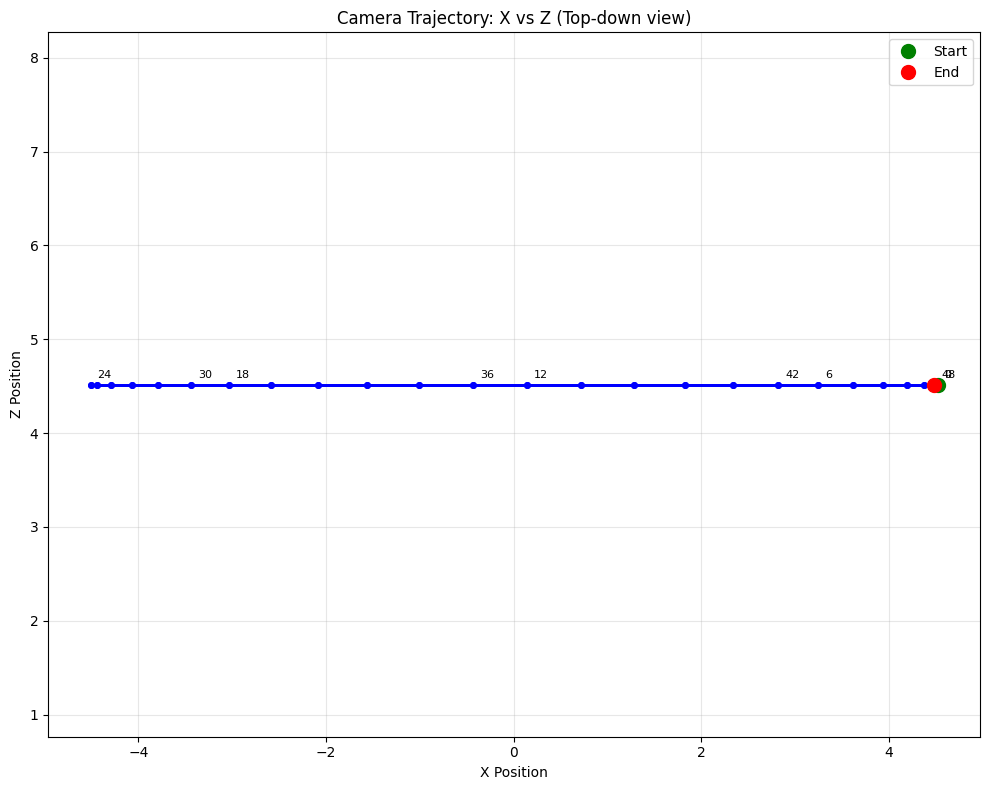

Trajectory shape: (49, 3)
X range: -4.509 to 4.518
Z range: 4.518 to 4.518
Start (X,Z): (4.518, 4.518)
End (X,Z): (4.481, 4.518)


In [104]:
# using maplotlib, plot the 0th and 2rd axis
# Using matplotlib, plot the 0th and 2nd axis of positions variable
plt.figure(figsize=(10, 8))

# Plot X vs Z (0th vs 2nd axis)
plt.plot(positions[:, 0], positions[:, 2], 'b-o', linewidth=2, markersize=4)
plt.xlabel('X Position')
plt.ylabel('Z Position') 
plt.title('Camera Trajectory: X vs Z (Top-down view)')
plt.grid(True, alpha=0.3)
plt.axis('equal')

# Mark start and end points
plt.plot(positions[0, 0], positions[0, 2], 'go', markersize=10, label='Start')
plt.plot(positions[-1, 0], positions[-1, 2], 'ro', markersize=10, label='End')

# Add frame numbers for reference
for i in range(0, len(positions), max(1, len(positions)//8)):
    plt.annotate(f'{i}', (positions[i, 0], positions[i, 2]), 
                xytext=(5, 5), textcoords='offset points', fontsize=8)

plt.legend()
plt.tight_layout()
plt.show()

# Print the trajectory values
print(f"Trajectory shape: {positions.shape}")
print(f"X range: {positions[:, 0].min():.3f} to {positions[:, 0].max():.3f}")
print(f"Z range: {positions[:, 2].min():.3f} to {positions[:, 2].max():.3f}")
print(f"Start (X,Z): ({positions[0, 0]:.3f}, {positions[0, 2]:.3f})")
print(f"End (X,Z): ({positions[-1, 0]:.3f}, {positions[-1, 2]:.3f})")

In [82]:
# Check the coordinate system by examining a few poses
poses = new_data['pose_target'].cpu().numpy()
print("Shape:", poses.shape)
print("\nFirst pose (Frame 0):")
print(poses[0])
print("\nPosition:", poses[0][:3, 3])
print("Rotation matrix:")
print(poses[0][:3, :3])

# Check if it follows OpenCV or OpenGL convention
print("\nCoordinate system analysis:")
print("Z-axis (forward direction):", poses[0][:3, 2])
print("Y-axis (up direction):", poses[0][:3, 1]) 
print("X-axis (right direction):", poses[0][:3, 0])

Shape: (49, 4, 4)

First pose (Frame 0):
[[-1.         0.         0.         0.       ]
 [ 0.         1.         0.         0.       ]
 [ 0.         0.        -1.         4.5181384]
 [ 0.         0.         0.         1.       ]]

Position: [0.        0.        4.5181384]
Rotation matrix:
[[-1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0. -1.]]

Coordinate system analysis:
Z-axis (forward direction): [ 0.  0. -1.]
Y-axis (up direction): [0. 1. 0.]
X-axis (right direction): [-1.  0.  0.]
